# Metal-Archives reviews - Part 1: Exploratory analysis

## Module imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

## Dataset

In [2]:
pd.options.display.float_format = "{:.2f}".format
df = pd.read_csv("reviews.csv")
df['review_score'] = df['review_title'].str.extract('(\d+)\%$', expand=False).astype(int)

In [3]:
print(f"average album review: {df['album_review_avg'].mean():.1f}")
print(f"average number of reviews: {df['album_review_num'].mean():.1f}")
print(f"highest number of reviews: {df['album_review_num'].max():}")

average album review: 79.1
average number of reviews: 9.4
highest number of reviews: 40


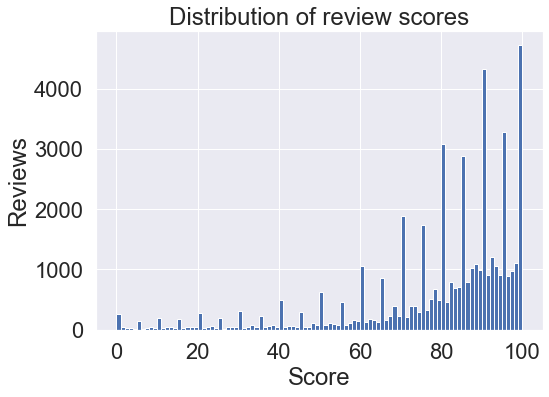

In [4]:
df['review_score'].hist(bins=100)
plt.title("Distribution of review scores")
plt.xlabel("Score")
plt.ylabel("Reviews")
plt.show()

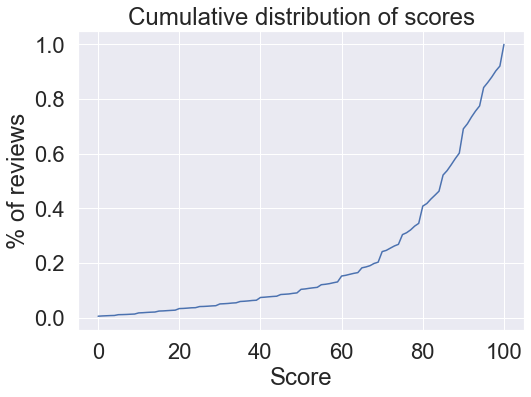

In [5]:
plt.plot(df['review_score'].value_counts().sort_index().cumsum() / len(df['review_score']))
plt.title("Cumulative distribution of scores")
plt.xlabel("Score")
plt.ylabel("% of reviews")
plt.show()

## Split dataset by album, band, genre, and country

In [6]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out

all_genres = df['band_genre'].apply(process_genre)
genres = sorted(set(all_genres.sum()))
for genre in genres:
    df.loc[:, 'genre_' + genre] = all_genres.apply(lambda x: int(genre in x))
print(df.columns)

Index(['band_name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label',
       ...
       'genre_technical', 'genre_techno', 'genre_thrash', 'genre_trance',
       'genre_tribal', 'genre_trip', 'genre_various', 'genre_viking',
       'genre_wave', 'genre_with'],
      dtype='object', length=130)


E:\anaconda3\envs\metallyrics\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


#### By album

In [7]:
df_albums = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby(['band_name', 'album_name']).first()
df_albums['album_review_avg'] = df.groupby(['band_name', 'album_name'])['review_score'].mean()
df_albums['album_review_std'] = df.groupby(['band_name', 'album_name'])['review_score'].std()
df_albums['album_review_num'] = df.groupby(['band_name', 'album_name']).apply(len)
df_albums.reset_index(inplace=True)
df_albums.rename(
    columns={c: re.sub(r"^(album_)", "", c) for c in df_albums.columns if re.match(r"^(album_)", c)},
    inplace=True
)
print(df_albums.columns)

Index(['band_name', 'name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes',
       ...
       'genre_techno', 'genre_thrash', 'genre_trance', 'genre_tribal',
       'genre_trip', 'genre_various', 'genre_viking', 'genre_wave',
       'genre_with', 'review_std'],
      dtype='object', length=127)


In [8]:
len(df_albums)

10100

#### By band

In [9]:
df_bands = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby('band_name').first()
df_bands['band_review_avg'] = df.groupby('band_name')['review_score'].mean()
df_bands['band_review_std'] = df.groupby('band_name')['review_score'].std()
df_bands['band_review_num'] = df.groupby('band_name').apply(len)
df_bands.reset_index(inplace=True)
df_bands.rename(
    columns={c: re.sub(r"^(band_)", "", c) for c in df_bands.columns if re.match(r"^(band_)", c)},
    inplace=True
)
print(df_bands.columns)

Index(['name', 'id', 'url', 'country_of_origin', 'location', 'status',
       'formed_in', 'genre', 'lyrical_themes', 'last_label',
       ...
       'genre_trance', 'genre_tribal', 'genre_trip', 'genre_various',
       'genre_viking', 'genre_wave', 'genre_with', 'review_avg', 'review_std',
       'review_num'],
      dtype='object', length=129)


In [10]:
len(df_bands)

1787

#### By genre

This split is a little different from the rest because there can be multiple genres per row.

In [11]:
genre_dfs = {}
for genre in genres:
    genre_dfs[genre] = df[df['genre_' + genre] > 0]
df_genres = pd.DataFrame(index=pd.Series(genres, name='genre'))
for genre, genre_df in genre_dfs.items():
    df_genres.loc[genre, 'review_avg'] = genre_df['review_score'].mean()
    df_genres.loc[genre, 'review_std'] = genre_df['review_score'].std()
    df_genres.loc[genre, 'review_num'] = len(genre_df)
print(df_genres.columns)

Index(['review_avg', 'review_std', 'review_num'], dtype='object')


#### By country of origin

In [12]:
df_countries = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby('band_country_of_origin').first()
df_countries['review_avg'] = df.groupby('band_country_of_origin')['review_score'].mean()
df_countries['review_std'] = df.groupby('band_country_of_origin')['review_score'].std()
df_countries['review_num'] = df.groupby('band_country_of_origin').apply(len)
df_countries.reset_index(inplace=True)
df_countries.rename(columns={'band_country_of_origin': 'country_of_origin'}, inplace=True)
print(df_countries.columns)

Index(['country_of_origin', 'band_name', 'band_id', 'band_url',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label',
       ...
       'genre_trance', 'genre_tribal', 'genre_trip', 'genre_various',
       'genre_viking', 'genre_wave', 'genre_with', 'review_avg', 'review_std',
       'review_num'],
      dtype='object', length=129)


## Weighted-average album score

Compare albums by simply looking at average review ratings fails to consider each album's popularity (or infamy).
This is important when the number of reviews per album vary dramatically.
Just like looking at product reviews, we naturally assign more weight to album review scores
that are averaged from the experiences of many people.

As you can see below, there are plenty of albums on MA with only a single, 100% review.
It doesn't make much sense to say these albums are all better than the most popular albums.
Likewise, there are plenty of albums with only a single 0% review.
The same can be seen when splitting the data by band.
I could apply a minimum number of reviews required to consider an album's review score legitimate,
but this shrinks down the dataset considerably and still weighs albums near the cutoff number and
near the maximum equally.

Instead, I will use a weighted-average score that treats individual reviews for an album as "evidence"
that the album ought to deviate from the population mean (of 79%).
Ideally, this method would distinguish good albums based on them having many positive reviews, not just a handful.
Likewise, it should help us reveal which albums draw a consensus of disdain from the MA community.

In [13]:
df_albums.sort_values('review_avg', ascending=False)[['band_name', 'name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,band_name,name,review_avg,review_num
1,Nightmare,Cosmovision,100,1
2,Spiritual Beggars,Demons,100,1
3,Plasmatics,Coup d'Ã‰tat,100,1
4,Moloch,Человечье слишком овечье,100,1
5,Moloch,Meine alte Melancholie,100,1


In [14]:
df_albums.sort_values('review_avg', ascending=True)[['band_name', 'name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,band_name,name,review_avg,review_num
1,Boris,Warpath,0,1
2,Kult ov Azazel,Destroying the Sacred,0,1
3,Car Door Dick Smash,Garbage,0,1
4,Opera IX,Anphisbena,0,1
5,Intronaut,The Direction of Last Things,0,1


In [256]:
df_bands.sort_values('review_avg', ascending=False)[['name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,name,review_avg,review_num
1,Gorement,100.00,6
2,Ocean Machine,96.10,10
3,Deathwish,95.67,9
4,Acid Bath,95.29,24
5,Tyrant of Death,95.14,7


In [257]:
df_bands.sort_values('review_avg', ascending=True)[['name', 'review_avg', 'review_num']].reset_index(drop=True).shift(1).loc[1:5].convert_dtypes()

,name,review_avg,review_num
1,Car Door Dick Smash,6.67,6
2,Chainsaw Penis,15.00,5
3,Skinlab,19.33,15
4,Thrash or Die,19.87,15
5,Animae Capronii,22.60,10


#### Rating albums using Bayesian-weighted averaging

Supposedly IMDb rates content using the following
[weighted averaging scheme](https://www.quora.com/How-does-IMDbs-rating-system-work):

$$ W_i = \frac{R_in_i + Cm}{n_i + m} $$

where $R_i$ and $n_i$ are average score and number of scores for a sample $i$
(a movie in the IMDb case, an album in our case),
$C = \sum_{i=1}^n R_i$ represents the average of the full collection of scores,
which I'll call the population mean,
and $m$ is a tunable threshold for the number of ratings required to be included in the Top-250 list (25,000).
(The page I linked uses $v$ for "votes" instead of $n$; I prefer this notation.)
The issue with this is that it does depend on our choice of $m$,
which would have to be tailored to the dataset.
One way to pick it is to choose some percentile of the album review count distribution.
Choosing a high percentile would give a higher number for $m$,
weighing the second term in the numerator more heavily.
This effectively gives more weight to the number of reviews,
since a larger $n_i$ is required to pull $W_i$ away from the population mean $C$.
The choice of $m$ therefore matters a lot, but it's chosen subjectively.
Ideally we should be weighing the population term in a way that reflects
how confident we are that the population mean describes individual samples.

This weighted averaging is inspired by Bayesian statistics:
the population parameter $C$ represents a prior belief about an album's true score,
and the weighted average updates that prior based on the observations $R_i n_i$.
We can define a weighted average more rigourously if we fully adopt a Bayesian framework.
Note that the album scores are distributed within the range 0-100,
much like probabilities of a binary process (e.g. flipping a coin).
Let's say an album has some "true" score that the reviewers are estimating,
like people guessing how likely a flipped coin will land on heads.
We might have some _prior_ belief about that how that coin might behave,
based on our understanding of how coins typically land.
We could then update that belief using our observations,
arriving at a _posterior_ estimate for the probability of landing heads.
In the case of the album reviews, the scores can be anywhere in the range 0-100,
rather than purely binary, but we'll see that it doesn't affect the math.
We can follow the classic example of determining the posterior distribution for a Beta-Bernoulli model,
in which we assume that the review scores for an album follow a Bernoulli distribution.

Let's describe the population distribution of scores using the
[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution),
using the population mean and variance to determine the appropriate $\alpha_0$ and $\beta_0$ parameters
(see the "mean and variance" section of the wiki page).
We can use this to represent our prior belief for the parameters of the model.
Importantly, the Beta distribution is the conjugate prior for the Bernoulli distribution,
meaning the posterior probability distribution is itself a Beta distribution.
The posterior for an album $i$ with $n_i$ reviews and an average rating of $R_i$
is a Beta distibution with the parameters

$$\alpha = s_i + \alpha_0$$
$$\beta = n_i - s_i + \beta_0$$

where $s_i$ is the number of sucessful trials (coins landing on heads),
which in our case is the average review rating times the number of reviews: $s_i = R_i n_i$.

The mean of a Beta distribution with parameters $\alpha$ and $\beta$ is given by

$$\mu = \frac{\alpha}{\alpha + \beta}$$

Thus we can define as our weighted-average score in terms of the sample and prior parameters:

$$\mu = \frac{R_i n_i + \alpha_0}{s_i + \alpha_0 + n_i - s_i + \beta_0}$$


$$\mu = \frac{R_i n_i + \alpha_0}{n_i + \alpha_0 + \beta_0}$$

Doing the same thing for the prior mean $\mu_0$ in terms of $\alpha_0$ and $\beta_0$, we get

$$\mu = \frac{R_i n_i + \mu_0 (\alpha_0 + \beta_0)}{n_i + (\alpha_0 + \beta_0)}$$

Look familiar? The prior mean is the same as the $C$ parameter in the IMDb average,
so the only difference between this formula and the other is that we now have a clear definition
for the $m$ parameter now: it's the sum of the Beta priors,
which are directly derived from the population mean and variance!

$$\alpha_0 + \beta_0 = \frac{1}{\sigma_0^2} \left(\mu_0 - \mu_0^2 - \sigma_0^2\right)$$

To be fair it's not obvious how this parameter behaves,
but generally speaking a more narrow distribution of reviews in the broad population would
yield a smaller variance $\sigma_0^2$, which has a similar effect to using a larger $m$ in the IMDb method.
This is the expected behavior; a small prior variance represents a more confident prior belief about the mean.
The key is that now we are allowing the prior variance to be based on the actual variance of the data,
rather than simply picking a number.

Implementing this is straightforward: we just have to compute the prior parameters from the full dataset,
then for each album use its average score and number of reviews to compute the parameters of the posterior distribution.
From the parameters we then compute the posterior mean and call that our weighted average.
Below are some examples of what the posteriors look like for some extreme examples
where clearly the weighted average favors/punishes large sample sizes.

In [70]:
from scipy.stats import beta

In [465]:
def beta_prior(x):
    mu = x.mean()
    var = x.std() ** 2
    a = mu * (mu * (1 - mu) / var - 1)
    b = (1 - mu) * (mu * (1 - mu) / var - 1)
    prior = beta(a, b)
    return prior


def beta_posteriors(data, prior):
    n = data['review_num']
    s = data['review_avg'] / 100 * n
    a_prior, b_prior = prior.args
    a_post = s + a_prior
    b_post = n - s + b_prior
    posts = [beta(a, b) for a, b in zip(a_post, b_post)]
    return posts

def weighted_scores(data, verbose=False):
    prior = beta_prior(data['review_avg'] / 100.)
    if verbose:
        print(f"Prior (alpha, beta) = ({prior.args[0]:.2f}, {prior.args[0]:.2f})")
        print(f"Prior weight = {sum(prior.args):.2f}")
    posteriors = beta_posteriors(data, prior)
    post_means = 100 * pd.Series([post.mean() for post in posteriors], index=data.index)
    return post_means

#### Examples

(5.57296148133675, 1.5193150608852508) 7.092276542222001
Prior mean = 79%

Album: Metallica - Ride the Lightning
Sample mean = 94%
Sample size = 30
Posterior mean = 91%

Album: Metallica - St. Anger
Sample mean = 45%
Sample size = 31
Posterior mean = 51%

Album: Nightmare - Cosmovision
Sample mean = 100%
Sample size = 1
Posterior mean = 81%

Album: Boris - Warpath
Sample mean = 0%
Sample size = 1
Posterior mean = 69%


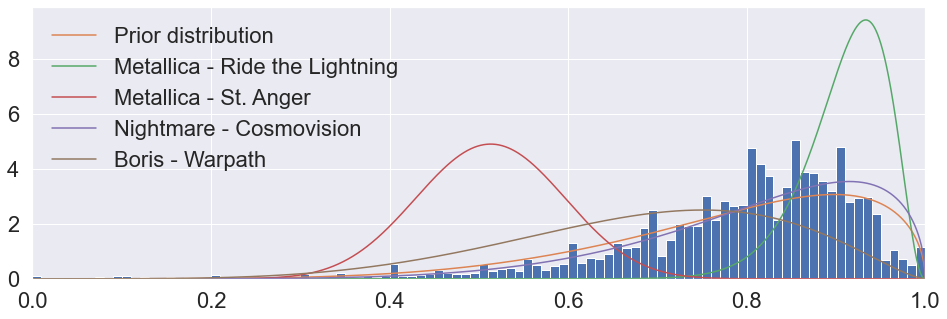

In [251]:
album_prior = beta_prior(df_albums['review_avg'] / 100.)
print(album_prior.args, sum(album_prior.args))
print(f"Prior mean = {100 * album_prior.mean():.0f}%")

album_posteriors = beta_posteriors(df_albums, album_prior)

plt.figure(figsize=(16, 5))
plt.hist(x, density=True, bins=100)
plt.plot(x_plot, prior.pdf(x_plot), label="Prior distribution")
plt.xlim(0, 1)

for name in ["Ride the Lightning", "St. Anger", "Cosmovision", "Warpath"]:
    i = df_albums.index[df_albums['name'] == name][0]
    post = album_posteriors[i]
    label = f"{df_albums.loc[i, 'band_name']} - {name}"
    print()
    print(f"Album: {label}")
    print(f"Sample mean = {df_albums.loc[i, 'review_avg']:.0f}%")
    print(f"Sample size = {df_albums.loc[i, 'review_num']:.0f}")
    print(f"Posterior mean = {100 * post.mean():.0f}%")
    plt.plot(x_plot, post.pdf(x_plot), label=label)

plt.legend()
plt.show()

(14.614102091079882, 3.754873155222502) 18.368975246302384
Prior mean = 80%

Band: Type O Negative
Sample mean = 92%
Sample size = 75
Posterior mean = 89%

Band: Waking the Cadaver
Sample mean = 32%
Sample size = 48
Posterior mean = 45%

Band: Gorement
Sample mean = 100%
Sample size = 6
Posterior mean = 85%

Band: Car Door Dick Smash
Sample mean = 7%
Sample size = 6
Posterior mean = 62%


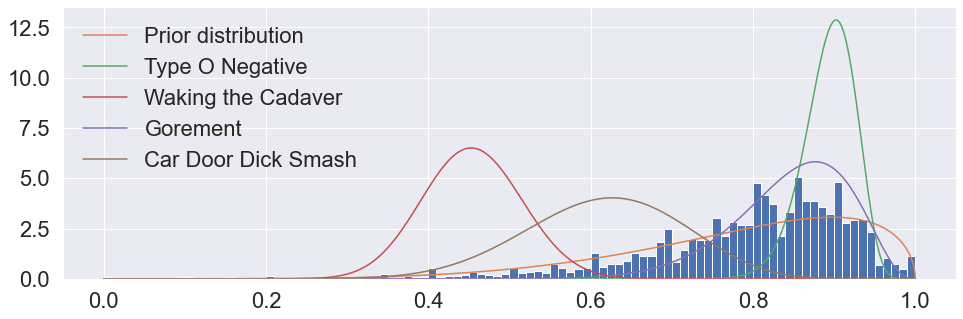

In [260]:
band_prior = beta_prior(df_bands['review_avg'] / 100.)
print(band_prior.args, sum(band_prior.args))
print(f"Prior mean = {100 * band_prior.mean():.0f}%")

band_posteriors = beta_posteriors(df_bands, band_prior)

plt.figure(figsize=(16, 5))
plt.hist(x, density=True, bins=100)
plt.plot(x_plot, prior.pdf(x_plot), label="Prior distribution")

for name in ["Type O Negative", "Waking the Cadaver", "Gorement", "Car Door Dick Smash"]:
    i = df_bands.index[df_bands['name'] == name][0]
    post = band_posteriors[i]
    print()
    print(f"Band: {name}")
    print(f"Sample mean = {df_bands.loc[i, 'review_avg']:.0f}%")
    print(f"Sample size = {df_bands.loc[i, 'review_num']:.0f}")
    print(f"Posterior mean = {100 * post.mean():.0f}%")
    plt.plot(x_plot, post.pdf(x_plot), label=name)

plt.legend()
plt.show()

(34.07120835211343, 9.21663991596091) 43.28784826807434
Prior mean = 79%

genre: doom
Sample mean = 83%
Sample size = 4710
Posterior mean = 83%

genre: groove
Sample mean = 70%
Sample size = 2880
Posterior mean = 70%

genre: egyptian
Sample mean = 90%
Sample size = 10
Posterior mean = 81%

genre: acoustic
Sample mean = 60%
Sample size = 54
Posterior mean = 68%


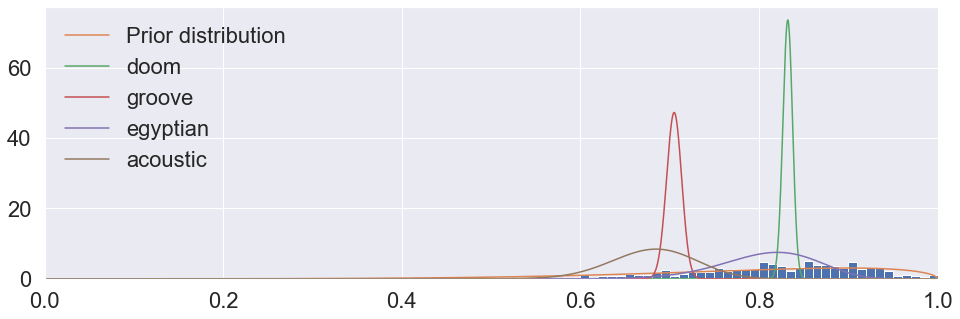

In [272]:
genre_prior = beta_prior(df_genres['review_avg'] / 100.)
print(genre_prior.args, sum(genre_prior.args))
print(f"Prior mean = {100 * genre_prior.mean():.0f}%")

genre_posteriors = beta_posteriors(df_genres, genre_prior)

plt.figure(figsize=(16, 5))
plt.hist(x, density=True, bins=100)
plt.plot(x_plot, prior.pdf(x_plot), label="Prior distribution")
plt.xlim(0, 1)

for i in ["doom", "groove", "egyptian", "acoustic"]:
    post = genre_posteriors[np.argmax(df_genres.index == i)]
    print()
    print(f"genre: {i}")
    print(f"Sample mean = {df_genres.loc[i, 'review_avg']:.0f}%")
    print(f"Sample size = {df_genres.loc[i, 'review_num']:.0f}")
    print(f"Posterior mean = {100 * post.mean():.0f}%")
    plt.plot(x_plot, post.pdf(x_plot), label=i)

plt.legend()
plt.show()

(24.947468743520147, 6.5157497550912495) 31.463218498611397
Prior mean = 79%

country: Japan
Sample mean = 83%
Sample size = 588
Posterior mean = 83%

country: Italy
Sample mean = 76%
Sample size = 988
Posterior mean = 77%

country: Lithuania
Sample mean = 88%
Sample size = 8
Posterior mean = 81%

country: Iraq
Sample mean = 40%
Sample size = 1
Posterior mean = 78%


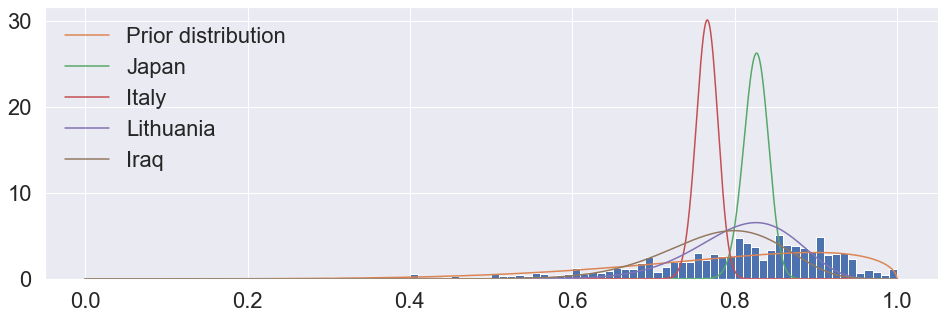

In [295]:
country_prior = beta_prior(df_countries['review_avg'] / 100.)
print(country_prior.args, sum(country_prior.args))
print(f"Prior mean = {100 * country_prior.mean():.0f}%")

country_posteriors = beta_posteriors(df_countries, country_prior)

plt.figure(figsize=(16, 5))
plt.hist(x, density=True, bins=100)
plt.plot(x_plot, prior.pdf(x_plot), label="Prior distribution")

for name in ["Japan", "Italy", "Lithuania", "Iraq"]:
    i = df_countries.index[df_countries['country_of_origin'] == name][0]
    post = country_posteriors[i]
    print()
    print(f"country: {name}")
    print(f"Sample mean = {df_countries.loc[i, 'review_avg']:.0f}%")
    print(f"Sample size = {df_countries.loc[i, 'review_num']:.0f}")
    print(f"Posterior mean = {100 * post.mean():.0f}%")
    plt.plot(x_plot, post.pdf(x_plot), label=name)

plt.legend()
plt.show()

#### Apply weighted score to dataset

In [446]:
df_albums['review_weighted'] = weighted_scores(df_albums, verbose=True)
df_albums['review_weighted'].describe()

Prior (alpha, beta) = (5.57, 5.57)
Prior weight = 7.09


count   10100.00
mean       78.72
std         4.86
min        33.39
25%        77.02
50%        79.40
75%        81.37
max        92.08
Name: review_weighted, dtype: float64

In [447]:
df_bands['review_weighted'] = weighted_scores(df_bands, verbose=True)
df_bands['review_weighted'].describe()

Prior (alpha, beta) = (14.61, 14.61)
Prior weight = 18.37


count   1787.00
mean      79.53
std        4.27
min       45.42
25%       77.70
50%       80.21
75%       82.11
max       89.38
Name: review_weighted, dtype: float64

In [448]:
df_genres['review_weighted'] = weighted_scores(df_genres, verbose=True)
df_genres['review_weighted'].describe()

Prior (alpha, beta) = (34.07, 34.07)
Prior weight = 43.29


count   106.00
mean     78.51
std       3.97
min      65.99
25%      77.23
50%      79.06
75%      80.99
max      84.98
Name: review_weighted, dtype: float64

In [449]:
df_countries['review_weighted'] = weighted_scores(df_countries, verbose=True)
df_countries['review_weighted'].describe()

Prior (alpha, beta) = (24.95, 24.95)
Prior weight = 31.46


count   64.00
mean    80.02
std      2.21
min     74.96
25%     78.50
50%     79.84
75%     81.18
max     84.74
Name: review_weighted, dtype: float64

#### Weighted score distribution

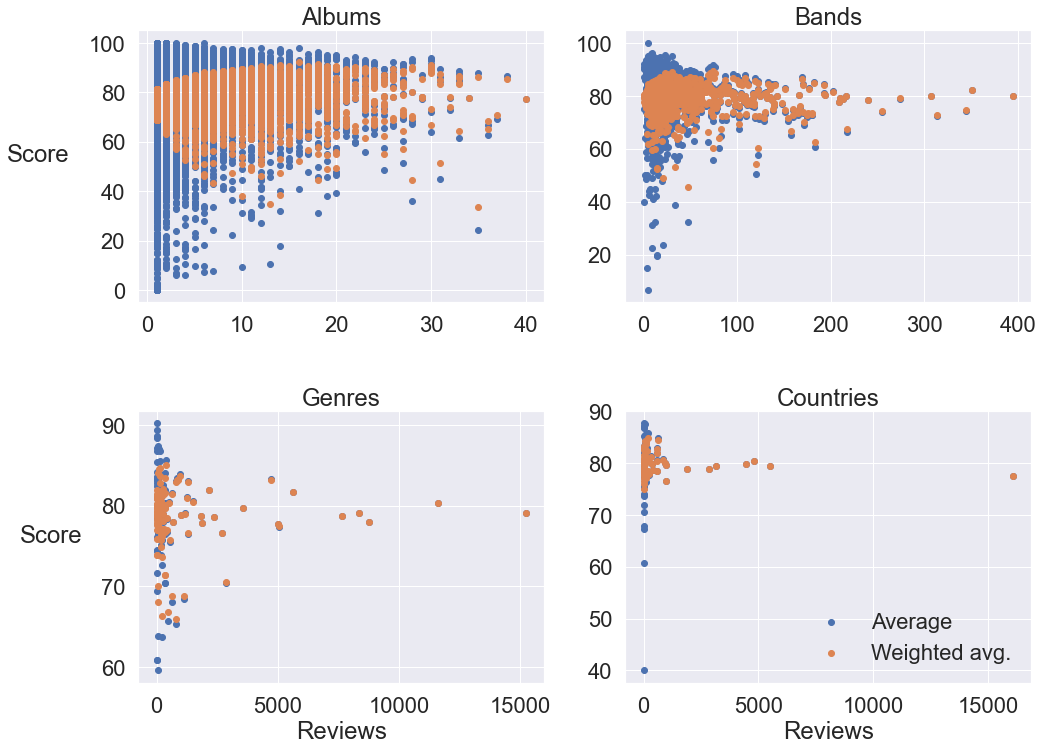

In [459]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4)

ax = ax.flatten()

for i, data in enumerate([df_albums, df_bands, df_genres, df_countries]):
    R = data['review_avg']
    n = data['review_num']
    weighted = data['review_weighted']
    ax[i].scatter(n, R, label="Average")
    ax[i].scatter(n, weighted, label="Weighted avg.")
ax[0].set_title("Albums")
ax[1].set_title("Bands")
ax[2].set_title("Genres")
ax[3].set_title("Countries")
ax[2].set_xlabel("Reviews")
ax[3].set_xlabel("Reviews")
ax[0].set_ylabel("Score", rotation=0, labelpad=50)
ax[2].set_ylabel("Score", rotation=0, labelpad=50)
ax[3].legend()
plt.show()

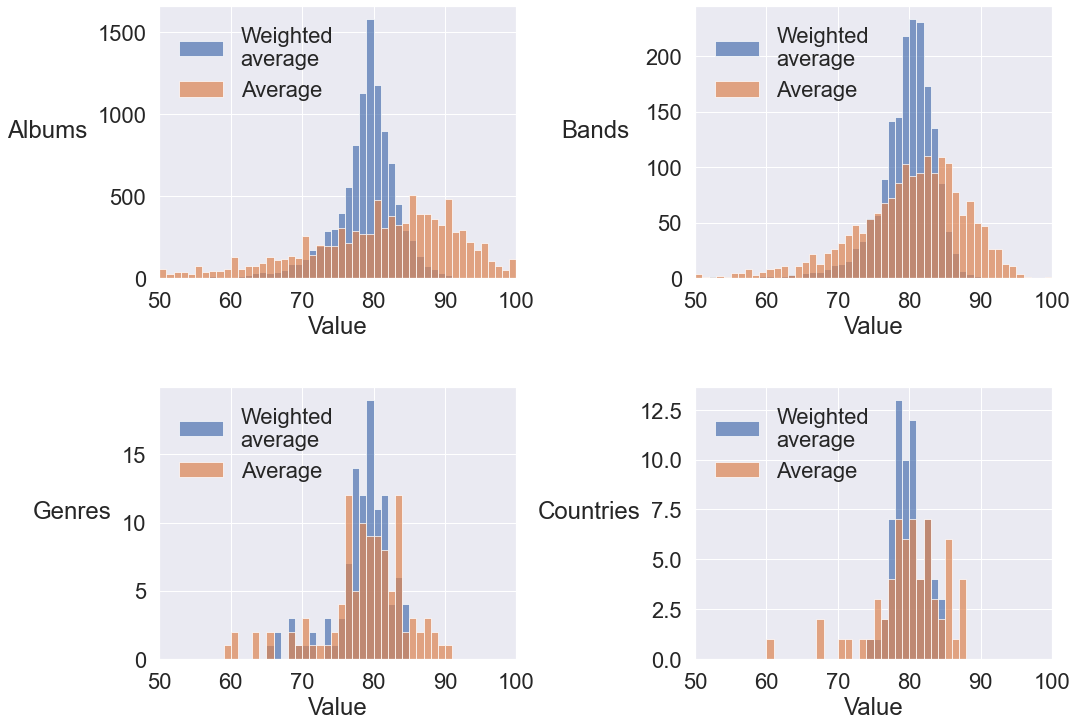

In [464]:
def plot_hist(data, ax, bins, ylabel):
    ax.hist(data['review_weighted'], bins=bins, alpha=0.7, label="Weighted\naverage")
    ax.hist(data['review_avg'], bins=bins, alpha=0.7, label="Average")
    ax.set_xlabel("Value")
    ax.set_ylabel(ylabel, rotation=0, labelpad=50)
    ax.set_xlim(50, 100)
    ax.legend(loc="upper left")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.subplots_adjust(wspace=0.5, hspace=0.4)

bins = 100
plot_hist(df_albums, ax1, np.linspace(0, 100, 101), "Albums")
plot_hist(df_bands, ax2, np.linspace(0, 100, 101), "Bands")
plot_hist(df_genres, ax3, np.linspace(0, 100, 101), "Genres")
plot_hist(df_countries, ax4, np.linspace(0, 100, 101), "Countries")

plt.show()

#### Best and worst albums

Metallica rides the lightning to the top of the weighted score ranking with their 1984 sophomore record.
Most of the top-20 albums hail from the 80s and 90s, a testament to their reputations as heavy metal classics.

In [355]:
review_cols = ['review_num', 'review_avg', 'review_weighted']

In [356]:
album_cols = ['band_name', 'name', 'year', 'band_genre'] + review_cols

In [357]:
df_albums[album_cols].sort_values('review_weighted', ascending=False).reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,band_name,name,year,band_genre,review_num,review_avg,review_weighted
1,Entombed,Left Hand Path,1990,Death Metal/Death 'n' Roll,16,98.06,92.08
2,Symphony X,The Divine Wings of Tragedy,1996,Progressive Power Metal,18,96.33,91.31
3,Riot V,Thundersteel,1988,Heavy/Power/Speed Metal,14,97.36,91.04
4,Metallica,Ride the Lightning,1984,Thrash Metal (early); Hard Rock (mid); Heavy/T...,30,93.93,91.00
5,Katatonia,Dance of December Souls,1993,"Doom/Death Metal (early), Depressive Rock/Meta...",19,95.21,90.69
6,Ahab,The Call of the Wretched Sea,2006,Funeral Doom Metal,20,94.95,90.66
7,Primordial,To the Nameless Dead,2007,Celtic Folk/Black Metal,12,97.75,90.63
8,Rush,Moving Pictures,1981,Hard Rock/Heavy Metal (early); Progressive Roc...,15,96.20,90.54
9,Bathory,Under the Sign of the Black Mark,1987,"Black/Viking Metal, Thrash Metal",17,95.47,90.50
10,Bolt Thrower,Realm of Chaos: Slaves to Darkness,1989,Death Metal,22,94.23,90.41


At the other end of the ranking, Waking the Cadaver's "Perverse Recollections of a Necromangler" is a clear outlier,
scoring significantly below the next worst album.
Metallica's infamous St. Anger does indeed get thrown to the gutters by the weighted scoring method.
Most of the worst albums were made by highly talented artists whose fans were expecting so much more.
It almost seems like a rite of passage to disappoint your fans after a decade or two of consistency.
Next we'll look at which bands have done well at _not_ pissing of the MA community.

In [358]:
df_albums[album_cols].sort_values('review_weighted').reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,band_name,name,year,band_genre,review_num,review_avg,review_weighted
1,Waking the Cadaver,Perverse Recollections of a Necromangler,2007,"Slam/Brutal Death Metal/Deathcore (early), Dea...",35,24.23,33.39
2,Hellyeah,Hellyeah,2007,Groove Metal,13,10.69,34.65
3,Six Feet Under,Graveyard Classics 2,2004,"Death/Groove Metal, Death 'n' Roll",10,9.30,38.05
4,Thrash or Die,Poser Holocaust,2011,Thrash Metal,14,17.86,38.27
5,Massacre,Promise,1996,Death Metal,7,7.86,43.45
6,Cryptopsy,The Unspoken King,2008,"Brutal/Technical Death Metal, Deathcore (2008)",18,31.00,44.45
7,Morbid Angel,Illud Divinum Insanus,2011,Death Metal,28,35.82,44.46
8,Six Feet Under,Graveyard Classics IV: The Number of the Priest,2016,"Death/Groove Metal, Death 'n' Roll",6,7.33,45.93
9,Queensrÿche,American Soldier,2009,Heavy/Power/Progressive Metal,12,27.17,46.26
10,Dark Moor,Project X,2015,Power Metal,6,9.50,46.92


#### Best and worst bands

To accumulate a high weighted-average score, a band must put out many albums, each garnering many positive reviews.
Any below-average albums will drag a band's weighted score down.
Based on this metric, Death is the most successful metal band.
Given their discography this is no surprise.
These guys really didn't know how to put out a bad album.
Their lowest reviewed full-length record, "The Sound of Perseverance" averaged just 1% below the 79% global average,
while the rest sit above 81%.
There's quite a lot of variety the top few bands: Type O Negative, Agra, Candlemass, and Rush!

In [359]:
band_cols = ['name', 'genre'] + review_cols

In [360]:
df_bands[band_cols].sort_values('review_weighted', ascending=False).reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,name,genre,review_num,review_avg,review_weighted
1,Type O Negative,Gothic/Doom Metal,75,91.79,89.38
2,Evoken,Funeral Doom/Death Metal,31,94.84,89.15
3,Moonsorrow,Folk/Pagan/Black Metal,72,91.06,88.72
4,Angra,Power/Progressive Metal,77,90.83,88.66
5,Acid Bath,Sludge/Doom Metal,24,95.29,88.47
6,Satan,"NWOBHM, Heavy Metal",26,94.04,88.04
7,Primordial,Celtic Folk/Black Metal,69,90.01,87.82
8,Esoteric,Funeral Doom/Death Metal,32,92.34,87.68
9,The Ruins of Beverast,Atmospheric Black/Doom Metal,34,91.82,87.52
10,Morbid Saint,Thrash Metal,24,93.12,87.24


Among the lowest-rated bands, with Six Feet Under earning the worst weighted score.
At least Waking the Cadaver manage to dodge last place this time.

In [361]:
df_bands[band_cols].sort_values('review_weighted', ascending=True).reset_index(drop=True).shift(1).loc[1:20].convert_dtypes()

,name,genre,review_num,review_avg,review_weighted
1,Waking the Cadaver,"Slam/Brutal Death Metal/Deathcore (early), Dea...",48,32.35,45.42
2,Hellyeah,Groove Metal,22,23.73,49.13
3,Skinlab,"Groove Metal (early), Nu-Metal (later)",15,19.33,52.49
4,Thrash or Die,Thrash Metal,15,19.87,52.73
5,Winds of Plague,Symphonic Deathcore,34,38.79,53.09
6,Six Feet Under,"Death/Groove Metal, Death 'n' Roll",121,50.52,54.35
7,Animae Capronii,Black Metal,10,22.60,59.48
8,Huntress,Heavy Metal,13,32.15,59.91
9,Machine Head,"Groove/Thrash Metal, Nu-Metal",123,57.51,60.38
10,Whitechapel,Deathcore,75,55.71,60.40


#### Best and worst genres

Doom metal tops the chart of total album score, followed closely by black and progressive metal.
There seems to be a preference for genres that emphasize long, instrumentally-focused song structures and fewer lyrics.
I can see how those genres are hard to hate, and therefore garner higher average reviews.
Reviewers might also find it easier to assess the quality of the albums on the basis of instrumentation.
These genres are also probably easier to listen to frequently enough to inspire writing reviews.

I'm pleasantly surprised to see progressive metal so high up.
Even in its unweighted average score is higher than I would have expected given some of the reviews I've seen
on my favorite prog metal bands.
I believe this is the result of "progressive" being more often used as a adjective prepended to other genres,
rather than as a genre itself.
The same could probably be said about avant-garde, which I imagine is being aided by its prevalence
as a sub-genre of black metal.

In [367]:
df_genres[review_cols].sort_values('review_weighted', ascending=False).reset_index().shift(1).loc[1:10].convert_dtypes()

,genre,review_num,review_avg,review_weighted
1,funeral,396,85.67,0.85
2,eastern,120,86.82,0.85
3,middle,103,87.03,0.85
4,and,69,87.38,0.84
5,avant-garde,974,83.90,0.84
6,grunge,120,85.47,0.84
7,pagan,363,84.05,0.83
8,doom,4710,83.26,0.83
9,viking,843,83.40,0.83
10,epic,895,83.36,0.83


At the bottom, groove metal, metalcore, and deathcore are perhaps to no one's surprise the lowest-scoring genres on MA.
Whether you like them or not, it seems they simply don't match the preferences of the typical MA reviewer.
A surprises here is thrash metal, with an average under 78% with nearly 9,000 reviews.
I'm guessing that, despite having plenty of highly praised artists,
the genre is stylistically saturated due to its consistent popularity over the decades.

In [368]:
df_genres[review_cols].sort_values('review_weighted', ascending=True).reset_index().shift(1).loc[1:10].convert_dtypes()

,genre,review_num,review_avg,review_weighted
1,deathcore,782,65.29,0.66
2,slam,209,63.74,0.66
3,nu-metal,453,65.68,0.67
4,acoustic,54,59.59,0.68
5,metalcore,1137,68.40,0.69
6,alternative,616,68.12,0.69
7,pop,62,63.92,0.70
8,groove,2880,70.37,0.70
9,roll,343,70.44,0.71
10,n,343,70.44,0.71


#### Best and worse countries

In [369]:
country_cols = ['country_of_origin'] + review_cols

In [370]:
df_countries[country_cols].sort_values('review_weighted', ascending=False).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,country_of_origin,review_num,review_avg,review_weighted
1,Ireland,184,85.67,0.85
2,Denmark,630,84.76,0.85
3,Iceland,47,87.53,0.84
4,Israel,95,85.48,0.84
5,Hungary,85,85.35,0.84
6,Colombia,64,85.41,0.83
7,Malta,33,87.00,0.83
8,Andorra,27,87.19,0.83
9,Singapore,53,84.79,0.83
10,Japan,588,82.78,0.83


In [371]:
df_countries[country_cols].sort_values('review_weighted', ascending=True).reset_index(drop=True).shift(1).loc[1:10].convert_dtypes()

,country_of_origin,review_num,review_avg,review_weighted
1,Philippines,19,67.79,0.75
2,Pakistan,7,60.71,0.76
3,Italy,988,76.50,0.77
4,Botswana,9,67.22,0.77
5,Belarus,11,70.45,0.77
6,International,96,76.32,0.77
7,United States,16069,77.51,0.78
8,Unknown,25,75.48,0.78
9,"Korea, South",11,73.55,0.78
10,Belgium,218,77.71,0.78


## Geographic distribution of albums and genres

#### Countries of origin

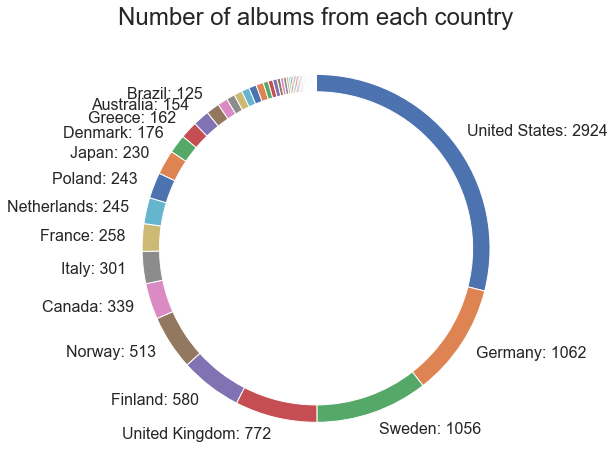

In [29]:
countries_num_albums = df_albums.groupby('band_country_of_origin').apply(len).sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(
    countries_num_albums.values,
    labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.01 * countries_num_albums.sum() else '')
            for country, num_albums in countries_num_albums.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 16},
)
ax.set_aspect('equal')
ax.set_title('Number of albums from each country')
plt.show()

#### U.S. states of origin

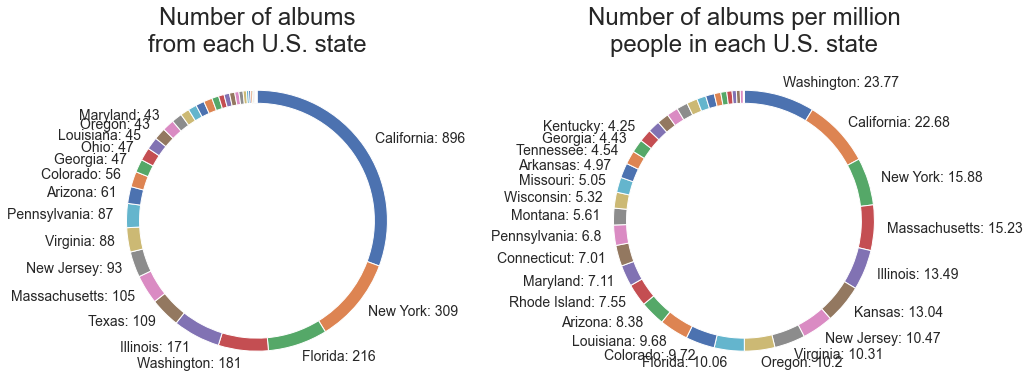

In [30]:
df_states = pd.read_csv('../../data/state_population/2019_Census_US_Population_Data_By_State_Lat_Long.csv')
state_pops = pd.Series(df_states['POPESTIMATE2019'].values, index=df_states['STATE'].rename('state'))
df_usa = df_albums[df_albums['band_country_of_origin'] == 'United States'].copy()
pattern = '(' + '|'.join(state_pops.index) + ')'
df_usa['state'] = df_usa['band_location'].str.extract(pattern)
states_num_albums = df_usa.groupby('state').apply(len).sort_values(ascending=False)
states_num_albums_density = states_num_albums / state_pops * 1e6
states_num_albums_density = states_num_albums_density.fillna(0).round(2).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.pie(
    states_num_albums.values,
    labels=[('{}: {}'.format(state, num_albums) if num_albums > 0.013 * states_num_albums.sum() else '')
            for state, num_albums in states_num_albums.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 14},
)
ax1.set_aspect('equal')
ax1.set_title("Number of albums\nfrom each U.S. state")
ax2.pie(
    states_num_albums_density.values,
    labels=[('{}: {}'.format(state, num_albums) if num_albums > 0.015 * states_num_albums_density.sum() else '')
            for state, num_albums in states_num_albums_density.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False,
    textprops={'fontsize': 14},
)
ax2.set_aspect('equal')
ax2.set_title("Number of albums per million\npeople in each U.S. state")
plt.show()

#### Top countries in each genre

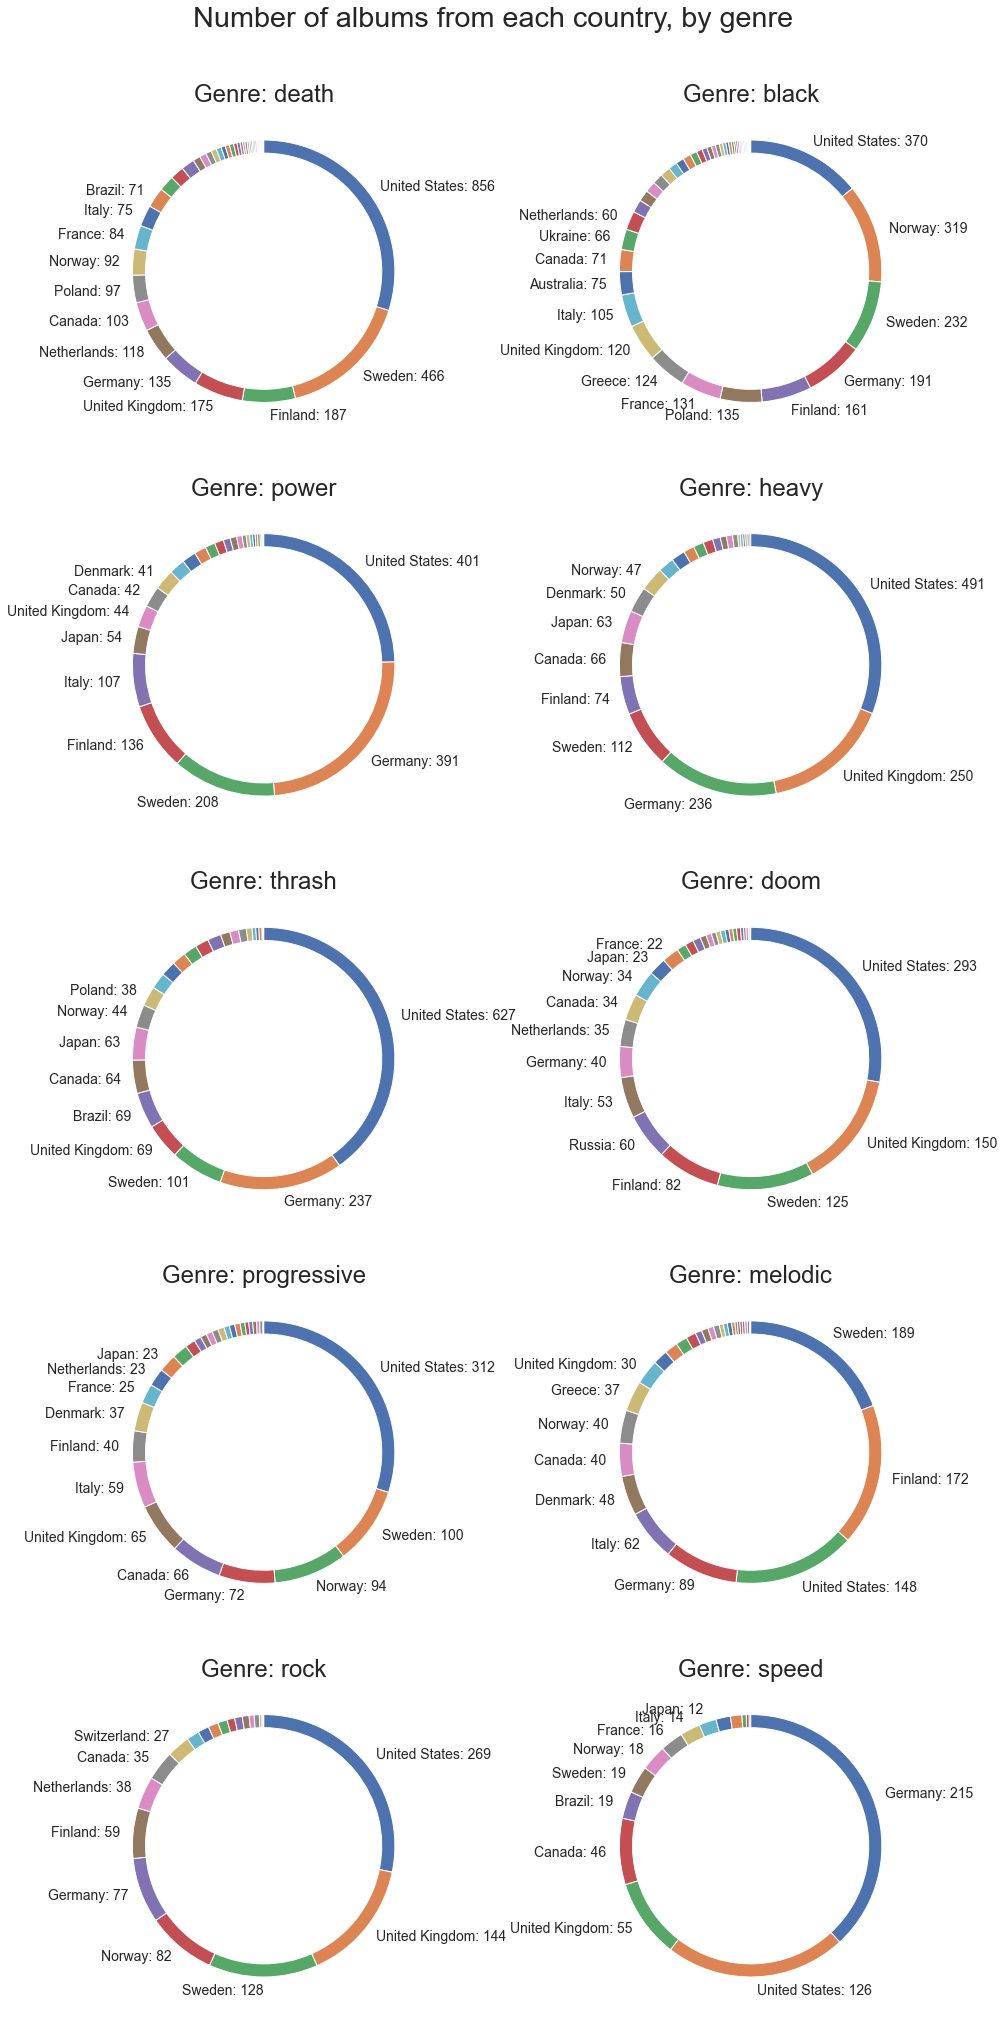

In [31]:
genres_num_albums = df_albums[[col for col in df_albums.columns if 'genre_' in col]].sum(0).sort_values(ascending=False)[:10]
fig, ax = plt.subplots(5, 2, figsize=(16, 35))
fig.suptitle("Number of albums from each country, by genre", y=0.92)
ax = ax.flatten()
for i, col in enumerate(genres_num_albums.index):
    countries_genre_num_albums = df_albums[df_albums[col] > 0].groupby('band_country_of_origin').apply(len).sort_values(ascending=False)
    ax[i].pie(
        countries_genre_num_albums.values,
        labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.02 * countries_genre_num_albums.sum() else '')
                for country, num_albums in countries_genre_num_albums.items()],
        wedgeprops=dict(width=0.1),
        startangle=90,
        counterclock=False,
        textprops={'fontsize': 14},
    )
    ax[i].set_aspect('equal')
    ax[i].set_title(f'Genre: {col[6:]}')
plt.show()

#### Top genres in each country

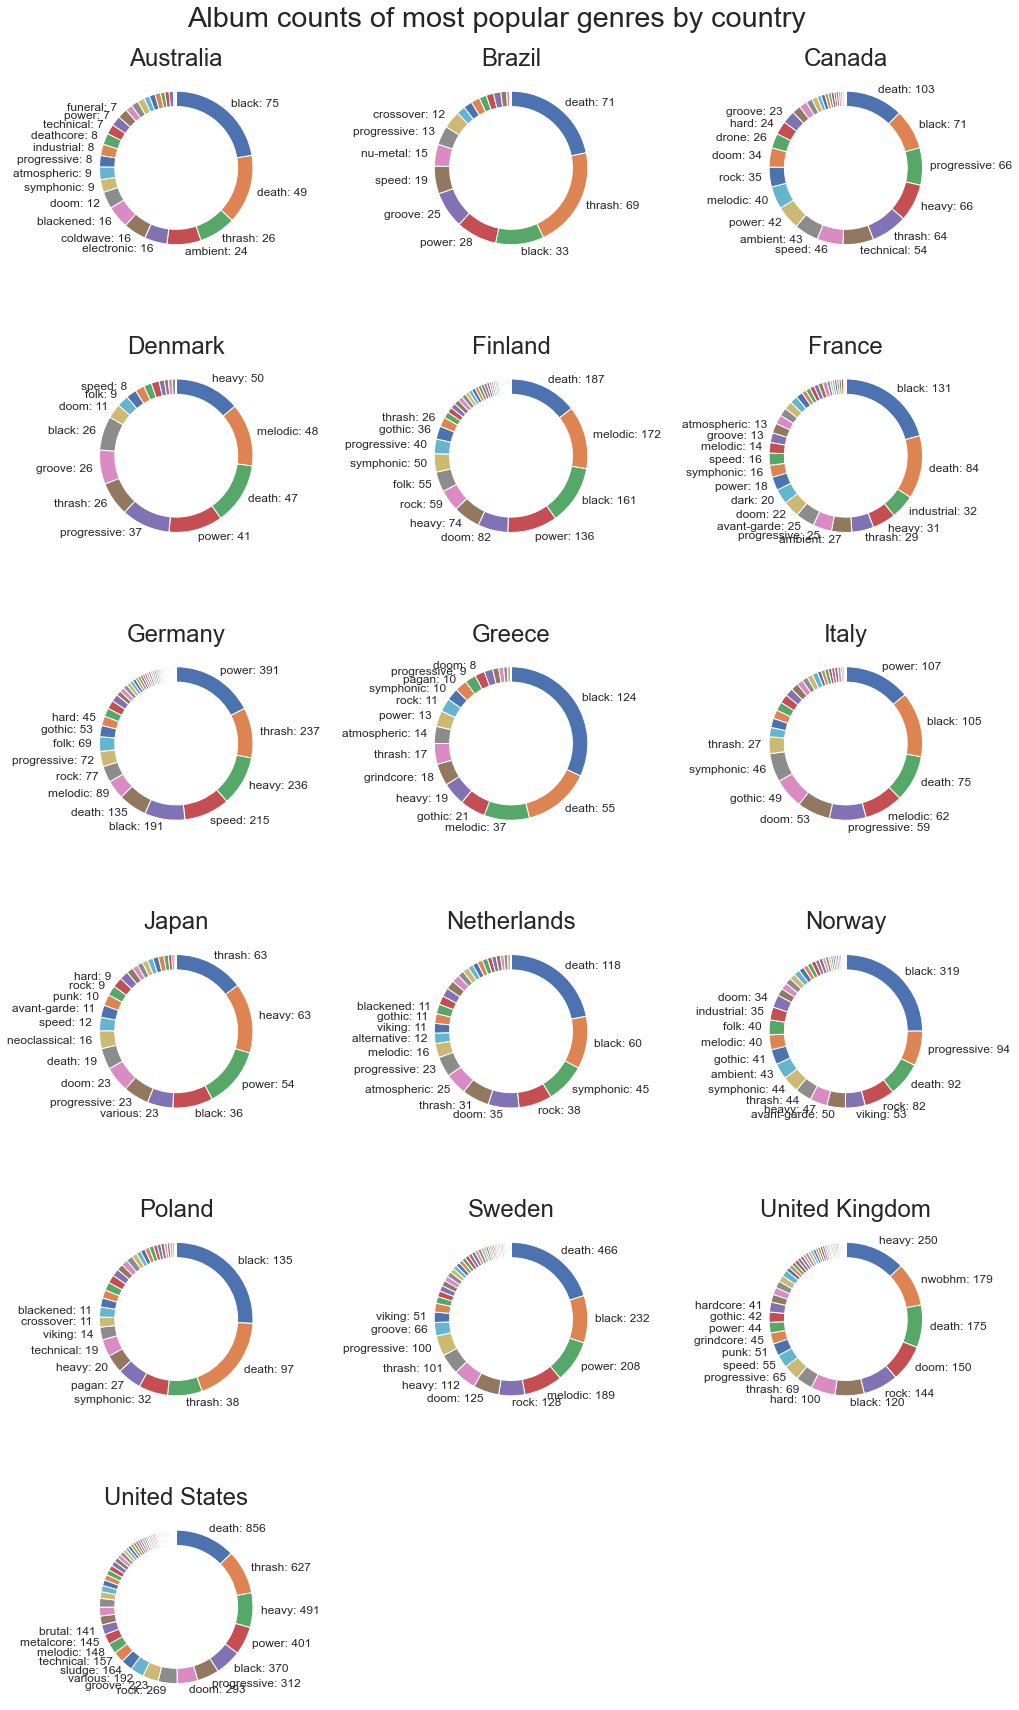

In [32]:
min_albums = 100
ncols = 3
country_albums = df_albums.groupby('band_country_of_origin').apply(len)
countries = country_albums[country_albums > min_albums].index
nrows = int(np.ceil(len(countries) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5 * nrows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("Album counts of most popular genres by country", y=0.91)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(countries):
        ax.set_axis_off()
        continue
    country = countries[i]
    df_country = df_albums[df_albums['band_country_of_origin'] == country]
    popular_genres = []
    albums_in_genre = []
    for genre in genres:
        num_albums = df_country['genre_' + genre].sum()
        popular_genres.append(genre)
        albums_in_genre.append(num_albums)
    x, y = [
        list(k[::-1]) for k in 
        zip(
            *sorted(
                zip(popular_genres, albums_in_genre),
                key=lambda pair: pair[1]
            )
        )
    ]
    ax.pie(
        y,
        labels=[('{}: {}'.format(country, num_albums) if num_albums > 0.02 * sum(y) else '')
                for country, num_albums in zip(x, y)],
        wedgeprops=dict(width=0.2),
        startangle=90,
        counterclock=False,
        textprops={'fontsize': 12},
    )
    ax.set_aspect('equal')
    ax.set_title(country)
plt.show()

## Decline of top-rated bands

If we grab a bunch of artists who've produced very high-scoring albums,
we can see the decline of these bands since their debut albums.
Most had at least one album better than their debut,
but it looks as if only Bolt Thrower has averaged above where they started.

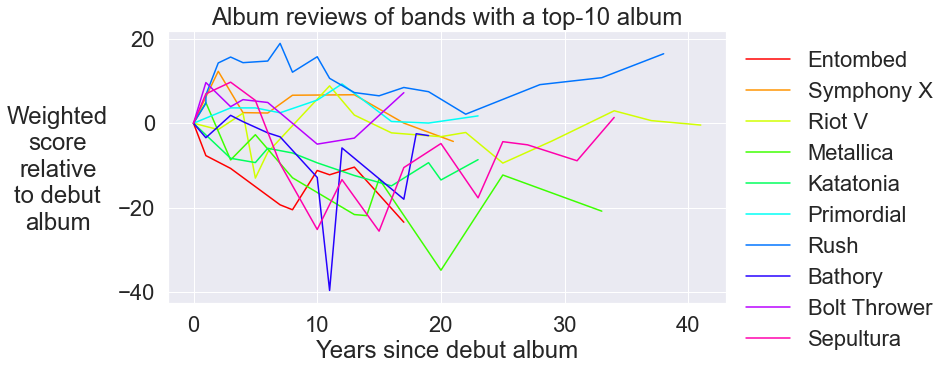

In [372]:
min_albums = 5
num_bands = 10
bands_album_counts = df_albums.groupby('band_name').apply(len)
bands_max_scores = df_albums.groupby('band_name')['review_weighted'].max()[bands_album_counts >= min_albums]
bands_top = bands_max_scores.sort_values(ascending=False).iloc[:num_bands].index
band_scores = {}
for band in bands_top:
    df_band = df_albums[df_albums['band_name'] == band].sort_values('year')
    band_scores[band] = (df_band['year'].values, df_band['review_weighted'].values)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cmap = plt.cm.hsv
ax.set_prop_cycle(color=[cmap(i) for i in np.linspace(0, 0.9, len(band_scores))])
for band, (years, scores) in band_scores.items():
    ax.plot(years - years.min(), scores - scores[0], label=band)
ax.set_title(f"Album reviews of bands with a top-{num_bands} album")
ax.set_xlabel("Years since debut album")
ax.set_ylabel("Weighted\nscore\nrelative\nto debut\nalbum", rotation=0, labelpad=60, y=0.25)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Global album trends

Now for a more comprehensive look.
We can see that the number of metal albums grew up until the late 2000's,
and has been in a sharp decline since.
Popularity, as determined by the annual average of weighted-average scores (fourth plot),
peaks towards the end of the 80s, about the same time that many of those top bands
from above were releasing their most iconic albums.
As the metal scene saturated, the quality dropped,
with scores hitting a low point that coincides with the peak in number of albums.

An alternative explanation could be that nostalgia inflates reviewers' opinions of earlier albums,
especially in those bands above whose quality floundered over the years.
There's little that can be done to test this hypothesis since all of the reviews of early albums here are written with hindsight,
but maybe in a few more years we can take another look and see if review sentiment shifts upward
as 2000s bands become the new nostalgia.

Although album production has nose-dived in the last few years,
and review rates for newer albums still trail behind those that have
been around for a while, recent records are performing much better
than those from the 2000s and early 2010s.
The annual weighted average is almost back to matching that of early 80s albums.

In [373]:
df_years = df[df.columns[df.columns.str.match('^(band_|album_|genre_)')]].groupby('album_year').first()
df_years['album_num'] = df.groupby(['album_year', 'album_name']).first().reset_index().groupby('album_year').apply(len)
df_years['review_avg'] = df.groupby('album_year')['review_score'].mean()
df_years['review_num'] = df.groupby('album_year').apply(len)
df_years.reset_index(inplace=True)
df_years.rename(columns={'album_year': 'year'}, inplace=True)
df_years['review_weighted'] = weighted_scores(df_years)

Prior (alpha, beta) = (87.24, 87.24)
Prior weight = 107.90


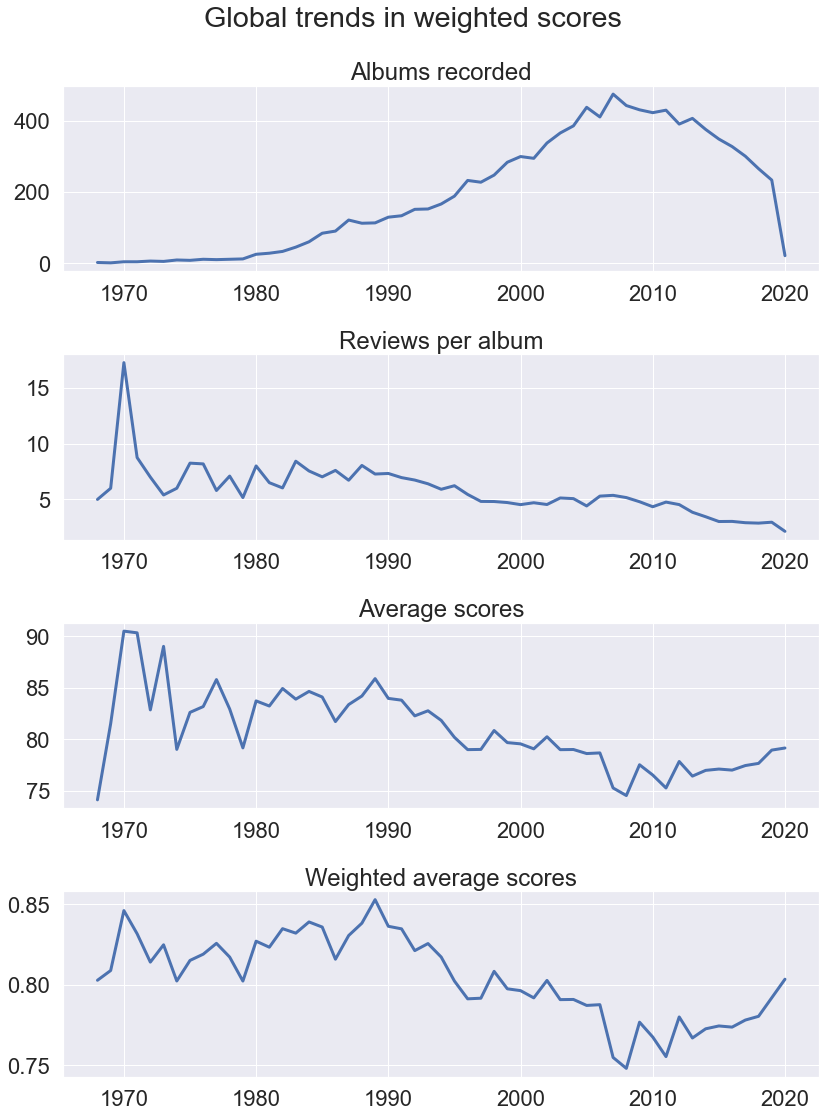

In [374]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
fig.subplots_adjust(hspace=0.3)
fig.suptitle("Global trends in weighted scores")
ax1.plot(df_years['year'], df_years['album_num'], lw=3)
ax2.plot(df_years['year'], df_years['review_num'] / df_years['album_num'], lw=3)
ax3.plot(df_years['year'], df_years['review_avg'], lw=3)
ax4.plot(df_years['year'], df_years['review_weighted'], lw=3)
ax1.set_title("Albums recorded")
ax2.set_title("Reviews per album")
ax3.set_title("Average scores")
ax4.set_title("Weighted average scores")
fig.tight_layout()
plt.show()

In [375]:
def padded_array(x, pad):
    return np.concatenate((np.ones(pad) * x[0], x, np.ones(pad) * x[-1]))

def smooth(x, kernel, w, pad):
    kernel /= kernel.sum()
    x_smooth = np.convolve(x, kernel, mode='same')
    std = np.sqrt(np.convolve((x - x_smooth)**2, kernel, mode='same'))
    if pad > 0:
        x_smooth = x_smooth[pad:-pad]
    if pad > 0:
        std = std[pad:-pad]
    return x_smooth, std

def gsmooth(x, w=1, pad='auto', kernel_threshold=1e-5):
    if w == 0:
        return x, np.zeros_like(x)
    if pad == 'auto':
        pad = w
    x_padded = padded_array(x, pad)
    kernel_x = np.linspace(-x.size, x.size, x_padded.size)
    sigma = w / (2 * np.sqrt(2 * np.log(2)))
    kernel = np.exp(-kernel_x**2 / (2 * sigma**2))
    kernel[kernel < kernel_threshold] = 0
    return smooth(x_padded, kernel, w, pad)

#### Yearly album output by genre

Although most genres contributed to the rise of metal in the 2000s,
black and death metal dominated the trend.
Before then, it was heavy metal and thrash metal that ruled supreme,
spearheading the 80s upswing that brought heavy metal into the public spotlight.

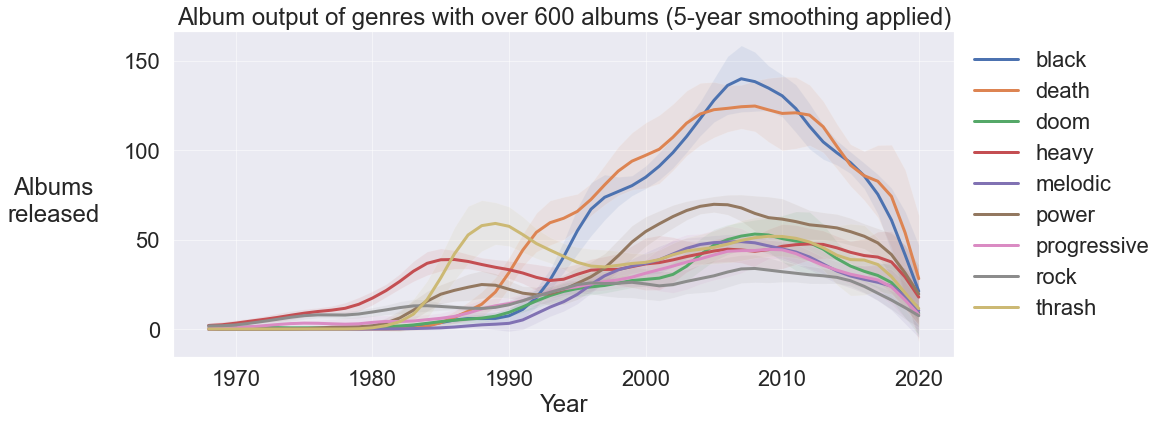

In [433]:
min_albums = 600
smoothing = 5
genre_years = df_albums.groupby('year')[df_albums.columns[df_albums.columns.str.contains('genre_')]].sum()
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for i, col in genre_years.iteritems():
    if col.sum() > min_albums:
        x = col.index
        y, y_std = gsmooth(col.values, smoothing)
        plt.plot(x, y, lw=3, label=i.replace('genre_', ''))
        plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
ax.set_xlabel("Year")
ax.set_ylabel("Albums\nreleased", rotation=0, labelpad=70, y=0.4)
ax.set_title(f"Album output of genres with over {min_albums} albums ({smoothing}-year smoothing applied)")
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

#### Yearly average album score

Here we see both genre-specific and global trends in the annual average of weighted-average scores.
Early doom metal (led by Black Sabbath) is very highly rated but has converged towards the average since then.
Early black metal albums likewise had a high-scoring start followed by gradual decline.

Prior (alpha, beta) = (52.86, 52.86)
Prior weight = 65.21
Prior (alpha, beta) = (83.10, 83.10)
Prior weight = 103.39
Prior (alpha, beta) = (32.03, 32.03)
Prior weight = 38.51
Prior (alpha, beta) = (118.29, 118.29)
Prior weight = 150.64
Prior (alpha, beta) = (48.84, 48.84)
Prior weight = 61.76
Prior (alpha, beta) = (98.52, 98.52)
Prior weight = 124.75
Prior (alpha, beta) = (46.05, 46.05)
Prior weight = 57.23
Prior (alpha, beta) = (95.92, 95.92)
Prior weight = 123.08
Prior (alpha, beta) = (52.34, 52.34)
Prior weight = 67.28


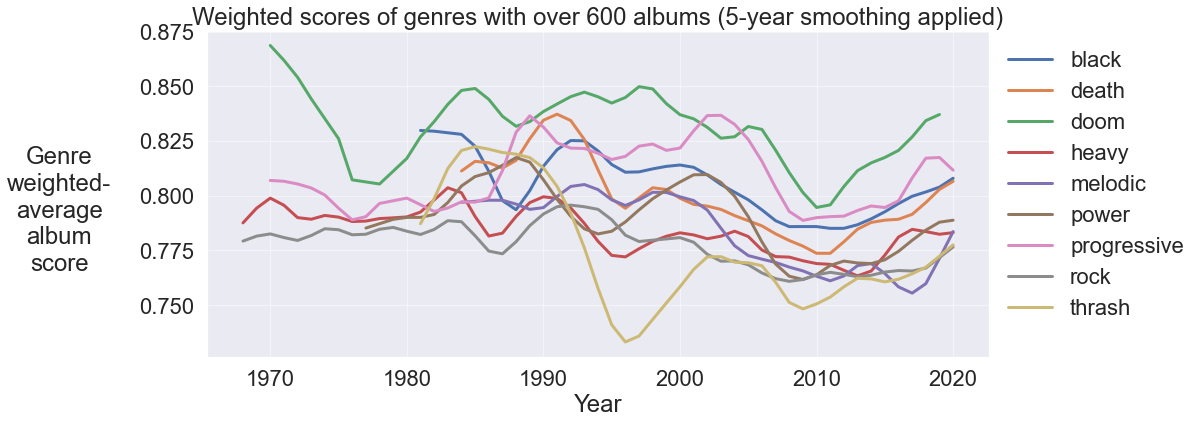

In [434]:
min_albums = 600
smoothing = 5
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for genre in df_genres.index:
    if len(df_albums[df_albums['genre_' + genre] > 0]) > min_albums:
        avg = df_albums[df_albums['genre_' + genre] > 0].groupby('year')['review_avg'].mean()
        num = df_albums[df_albums['genre_' + genre] > 0].groupby('year')['review_num'].sum()
        df_genre_year = pd.concat((avg, num), axis=1)
        series = weighted_scores(df_genre_year)
        x = series.index
        y, y_std = gsmooth(series.values, smoothing)
        plt.plot(x, y, lw=3, label=genre.replace('genre_', ''))
ax.set_xlabel("Year")
ax.set_ylabel("Genre\nweighted-\naverage\nalbum\nscore", rotation=0, labelpad=80, y=0.25)
ax.set_title(f"Weighted scores of genres with over {min_albums} albums ({smoothing}-year smoothing applied)")
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

## Geographic trends

These plots show just how consistently American bands have dominated the metal scence over the decades.
The U.K. was the first nation to pull ahead of others in producing metal albums,
but with the rise of the thrash era in the late 80s,
the U.S.A. took the lead and never lost it,
despite the Scandinavian black/death metal scene pulling some attention back across the Atlantic.

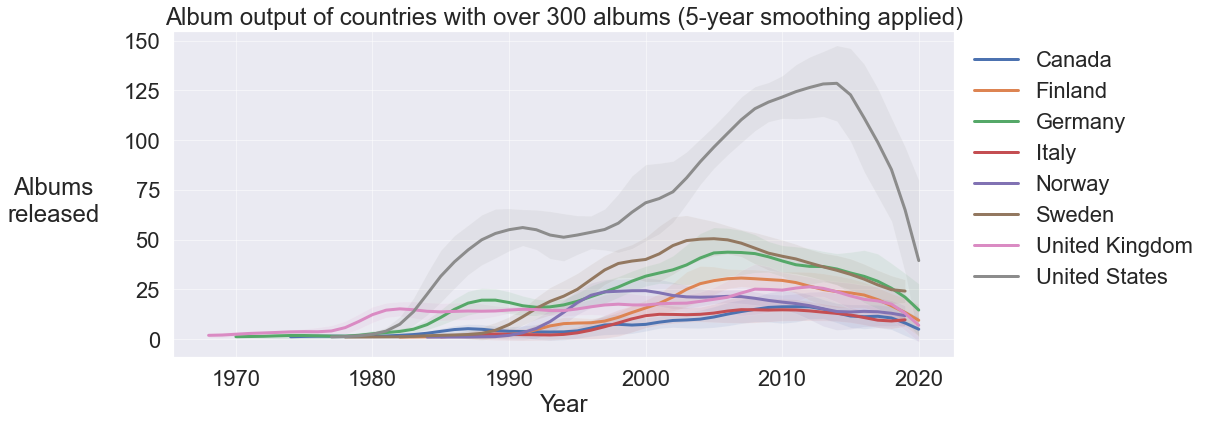

In [432]:
min_albums = 300
smoothing = 5
countries_albums = df_albums.groupby('band_country_of_origin').size()
countries = countries_albums[countries_albums > min_albums]
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for country in countries.index:
    df_country = df_albums[df_albums['band_country_of_origin'] == country]
    series = df_country.groupby('year').size()
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
    ax.plot(x, y, lw=3, label=country)
    ax.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
ax.set_xlabel("Year")
ax.set_ylabel("Albums\nreleased", rotation=0, labelpad=70, y=0.4)
ax.set_title(f"Album output of countries with over {min_albums} albums ({smoothing}-year smoothing applied)")
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)

The passing of trends is even more clear when looking at the weighted-average scores.
With each spike in national averages comes a new shift between genres;
the U.K.-to-U.S.A. transition marks the rise of thrash,
the U.S.A. gives way in the mid 80s to Swedish death metal,
and the Swedes hand the baton to their black metal neighbors in the 90s.
Sadly no nation was up to the task of ushering forth a new frontier in metal when the Norwegian scene entered its decline.

In [405]:
country = 'Canada'
avg = df_albums[df_albums['band_country_of_origin'] == country].groupby('year')['review_avg'].mean()
num = df_albums[df_albums['band_country_of_origin'] == country].groupby('year')['review_num'].sum()
df_country_year = pd.concat((avg, num), axis=1)
df_country_year['review_weighted'] = weighted_scores(df_country_year)

Prior (alpha, beta) = (33.89, 33.89)
Prior weight = 42.97


Prior (alpha, beta) = (33.89, 33.89)
Prior weight = 42.97
Prior (alpha, beta) = (13.33, 13.33)
Prior weight = 17.05
Prior (alpha, beta) = (72.12, 72.12)
Prior weight = 91.47
Prior (alpha, beta) = (21.76, 21.76)
Prior weight = 27.43
Prior (alpha, beta) = (60.90, 60.90)
Prior weight = 74.81
Prior (alpha, beta) = (51.11, 51.11)
Prior weight = 62.49
Prior (alpha, beta) = (32.81, 32.81)
Prior weight = 41.56
Prior (alpha, beta) = (44.03, 44.03)
Prior weight = 56.04


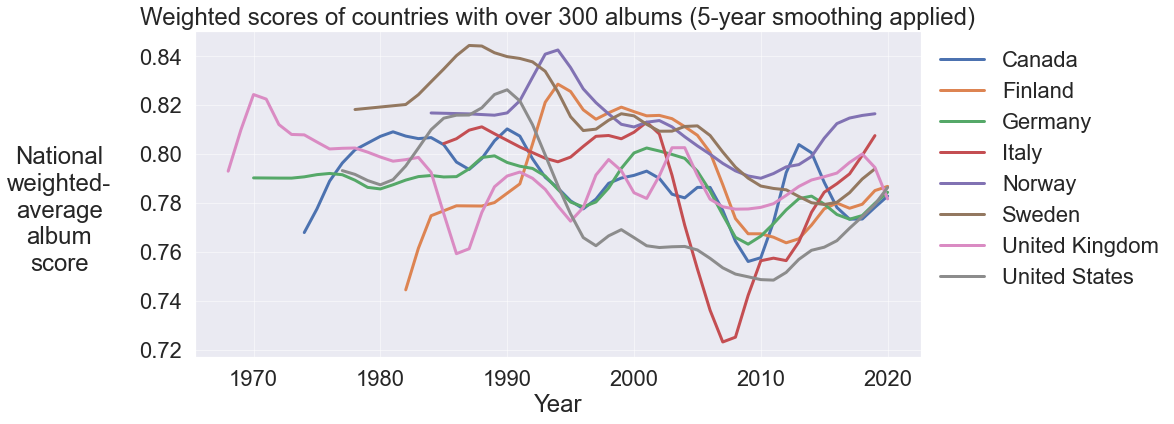

In [436]:
min_albums = 300
smoothing = 5
countries_albums = df_albums.groupby('band_country_of_origin').size()
countries = countries_albums[countries_albums > min_albums]
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
for country in countries.index:
    avg = df_albums[df_albums['band_country_of_origin'] == country].groupby('year')['review_avg'].mean()
    num = df_albums[df_albums['band_country_of_origin'] == country].groupby('year')['review_num'].sum()
    df_country_year = pd.concat((avg, num), axis=1)
    series = weighted_scores(df_country_year)
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
    ax.plot(x, y, lw=3, label=country)
ax.set_xlabel("Year")
ax.set_ylabel("National\nweighted-\naverage\nalbum\nscore", rotation=0, labelpad=80, y=0.25)
ax.set_title(f"Weighted scores of countries with over {min_albums} albums ({smoothing}-year smoothing applied)")
ax.legend(bbox_to_anchor=(1, 1))
ax.grid(alpha=0.5)
plt.show()